In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/DL Lab/Untitled folder/脑部MRI图像分割/brain-seg')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install medpy==0.4.0

     |████████████████████████████████| 151 kB 14.8 MB/s 
     |████████████████████████████████| 48.4 MB 30 kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754444 sha256=db16e470bf707c57a963879032f2d9c80f3a0e8f07b635ec6fae1b175dc3a6d3
  Stored in directory: /root/.cache/pip/wheels/b0/57/3a/da1183f22a6afb42e11138daa6a759de233fd977a984333602
Successfully built medpy


In [ ]:
!pip install tensorflow==2.0

     |████████████████████████████████| 86.3 MB 56.0 MB/s 
     |████████████████████████████████| 50 kB 7.2 MB/s 
     |████████████████████████████████| 449 kB 55.3 MB/s 
     |████████████████████████████████| 3.8 MB 54.6 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=b42e110d090be121788fe5cadf04f9a175bc8eb29416fda4314043e8264eb417
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succe

In [ ]:
!pip install scikit-image==0.14.2

     |████████████████████████████████| 25.3 MB 1.2 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install Pillow==6.0.0

     |████████████████████████████████| 2.0 MB 5.3 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 6.0.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install scipy==1.2.1

     |████████████████████████████████| 24.8 MB 47.0 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## 使用训练后的模型在验证集上进行推理

In [3]:
import os

import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from medpy.filter.binary import largest_connected_component
from skimage.io import imsave
from torch.utils.data import DataLoader

from dataset import BrainSegmentationDataset as Dataset
from nets import UNet
from utils import dsc, gray2rgb, outline

In [ ]:
# data loading
def data_loader(args):
    dataset = Dataset(
        images_dir=args.images,
        subset="validation",
        image_size=args.image_size,
        random_sampling=False,
    )
    loader = DataLoader(
        dataset, batch_size=args.batch_size, drop_last=False, num_workers=1
    )
    return loader

# data processing
def postprocess_per_volume(
    input_list, pred_list, true_list, patient_slice_index, patients
):
    volumes = {}
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0
    for p in range(len(num_slices)):
        volume_in = np.array(input_list[index : index + num_slices[p]])
        volume_pred = np.round(
            np.array(pred_list[index : index + num_slices[p]])
        ).astype(int)
        volume_pred = largest_connected_component(volume_pred)
        volume_true = np.array(true_list[index : index + num_slices[p]])
        volumes[patients[p]] = (volume_in, volume_pred, volume_true)
        index += num_slices[p]
    return volumes

# compute the dice coefficient
def dsc_distribution(volumes):
    dsc_dict = {}
    for p in volumes:
        y_pred = volumes[p][1]
        y_true = volumes[p][2]
        dsc_dict[p] = dsc(y_pred, y_true, lcc=False)
    return dsc_dict

# plot graph
def plot_dsc(dsc_dist):
    y_positions = np.arange(len(dsc_dist))
    dsc_dist = sorted(dsc_dist.items(), key=lambda x: x[1])
    values = [x[1] for x in dsc_dist]
    labels = [x[0] for x in dsc_dist]
    labels = ["_".join(l.split("_")[1:-1]) for l in labels]
    fig = plt.figure(figsize=(12, 8))
    canvas = FigureCanvasAgg(fig)
    plt.barh(y_positions, values, align="center", color="skyblue")
    plt.yticks(y_positions, labels)
    plt.xticks(np.arange(0.0, 1.0, 0.1))
    plt.xlim([0.0, 1.0])
    plt.gca().axvline(np.mean(values), color="tomato", linewidth=2)
    plt.gca().axvline(np.median(values), color="forestgreen", linewidth=2)
    plt.xlabel("Dice coefficient", fontsize="x-large")
    plt.gca().xaxis.grid(color="silver", alpha=0.5, linestyle="--", linewidth=1)
    plt.tight_layout()
    canvas.draw()
    plt.close()
    s, (width, height) = canvas.print_to_buffer()
    return np.fromstring(s, np.uint8).reshape((height, width, 4))

# make directory
def makedirs(args):
    os.makedirs(args.predictions, exist_ok=True)

In [ ]:
def main(args):
    makedirs(args)
    device = torch.device("cpu" if not torch.cuda.is_available() else args.device)

    loader = data_loader(args)

    with torch.set_grad_enabled(False):
        
        state_dict = torch.load(args.weights, map_location=device)
        args.net.load_state_dict(state_dict)
        args.net.eval()
        args.net.to(device)

        input_list = []
        pred_list = []
        true_list = []

        for i, data in enumerate(loader):
            x, y_true = data
            x, y_true = x.to(device), y_true.to(device)
            
            y_pred = args.net(x)
            y_pred_np = y_pred.detach().cpu().numpy()
            pred_list.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])

            y_true_np = y_true.detach().cpu().numpy()
            true_list.extend([y_true_np[s] for s in range(y_true_np.shape[0])])

            x_np = x.detach().cpu().numpy()
            input_list.extend([x_np[s] for s in range(x_np.shape[0])])

    volumes = postprocess_per_volume(
        input_list,
        pred_list,
        true_list,
        loader.dataset.patient_slice_index,
        loader.dataset.patients,
    )

    dsc_dist = dsc_distribution(volumes)

    dsc_dist_plot = plot_dsc(dsc_dist)
    imsave(args.figure, dsc_dist_plot)

    for p in volumes:
        x = volumes[p][0]
        y_pred = volumes[p][1]
        y_true = volumes[p][2]
        for s in range(x.shape[0]):
            image = gray2rgb(x[s, 1])  # channel 1 is for FLAIR
            image = outline(image, y_pred[s, 0], color=[255, 0, 0])
            image = outline(image, y_true[s, 0], color=[0, 255, 0])
            filename = "{}-{}.png".format(p, str(s).zfill(2))
            filepath = os.path.join(args.predictions, filename)
            imsave(filepath, image)

### 输入参数
 
device: 设备编号  
batch_size: 批大小  
weights: 训练后的模型参数路径  
images: 数据集路径  
image_size: 图像尺寸   
predictions: 推理结果的保存路径  
figure: 统计结果(Dice Coefficient)的保存路径 

In [ ]:
class Args:
    device = 'cuda:0'
    net = UNet(in_channels=3, out_channels=1, init_features=32)
    batch_size = 32
    weights = '/content/drive/MyDrive/Colab Notebooks/DL Lab/Untitled folder/脑部MRI图像分割/brain-seg/weights/weights-1/unet.pt'
    images = '/content/drive/MyDrive/Colab Notebooks/DL Lab/Untitled folder/脑部MRI图像分割/brain-seg/kaggle_3m'
    image_size = 256
    predictions = './predictions'
    figure = './dsc.png'

if __name__ == "__main__":
    args=Args()
    main(args)

reading validation images...
preprocessing validation volumes...
cropping validation volumes...
padding validation volumes...
resizing validation volumes...
normalizing validation volumes...
done creating validation dataset


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/usr/local/lib/python3.7/dist-packages/skimage/io/_io.py:140: UserWarning: ./predictions/TCGA_DU_7014_19860618-57.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.7/dist-packages/skimage/io/_io.py:140: UserWarning: ./predictions/TCGA_DU_6408_19860521-51.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.7/dist-packages/skimage/io/_io.py:140: UserWarning: ./predictions/TCGA_DU_6408_19860521-52.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.7/dist-packages/skimage/io/_io.py:140: UserWarning: ./predictions/TCGA_DU_6408_19860521-53.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.7/dist-packages/skimage/io/_io

In [11]:
!pip install rawpy

     |████████████████████████████████| 1.9 MB 14.4 MB/s 


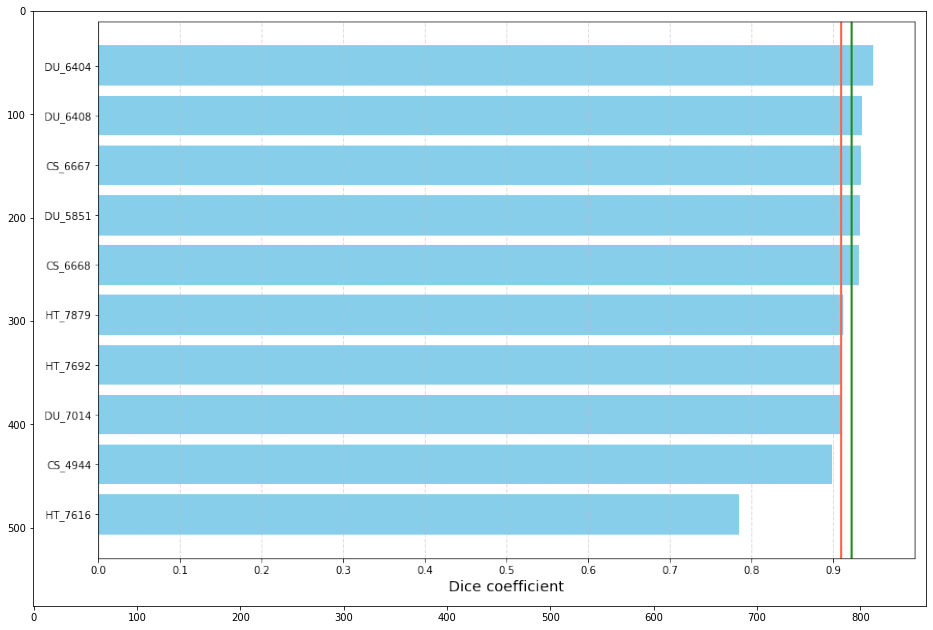

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv_imshow
import matplotlib.image as mpimg

dsc_dist = mpimg.imread('/content/drive/MyDrive/Colab Notebooks/DL Lab/Untitled folder/脑部MRI图像分割/brain-seg/dsc.png')
plt.figure(figsize=(16,16))
plt.imshow(dsc_dist) 
plt.show()

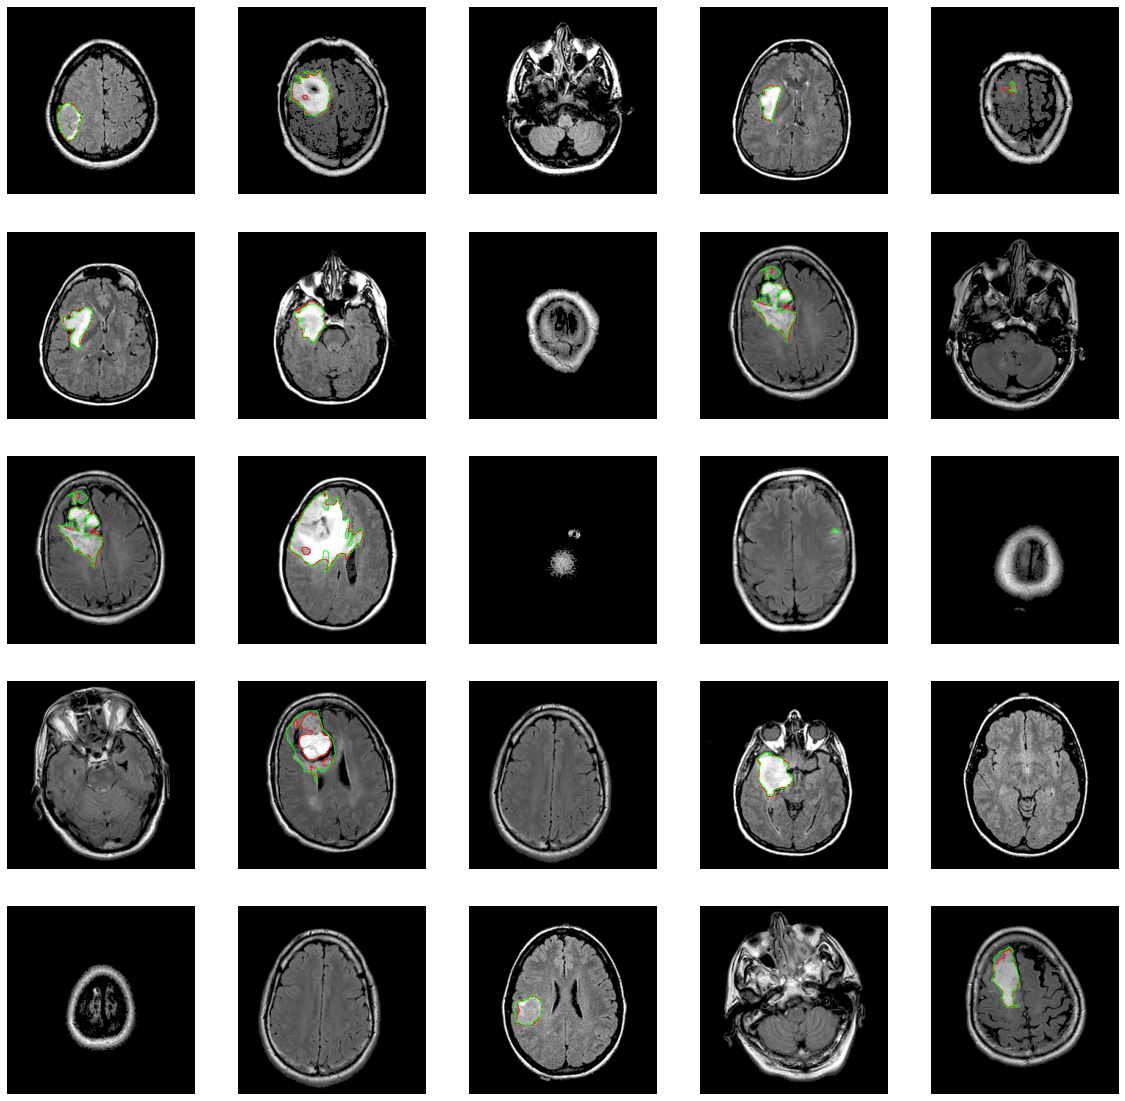

In [31]:
prediction_dir = '/content/drive/MyDrive/Colab Notebooks/DL Lab/Untitled folder/脑部MRI图像分割/brain-seg/predictions'
filenames = os.listdir(prediction_dir)
predictions = []
for filename in filenames:
    filepath = os.path.join(prediction_dir, filename)
    predictions.append(plt.imread(filepath))


figure = plt.figure(figsize=(20,20))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(predictions), size=(1,)).item()
    img = predictions[sample_idx]
    ax = figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img)

plt.show()